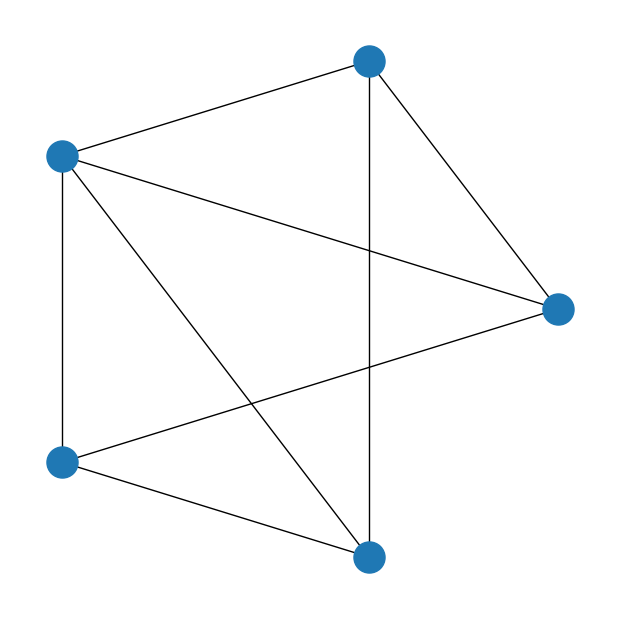

In [ ]:
import numpy as np
from itertools import permutations
from src.viz import simple_graph_from_adj, plot_sbm
from src.sbm import generate_sbm, MySbmFromScratch
from src.utils import get_adjancy, random_permute_adj, convert_to_ranks
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx
import random
import torch
from itertools import permutations
from tqdm import trange
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

matrix = np.array([[0,1,1,1,0],
                  [1,0,1,0,1],
                  [1,1,0,1,1],
                  [1,0,1,0,1],
                  [0,1,1,1,0]])

simple_graph_from_adj(matrix, labels=False)

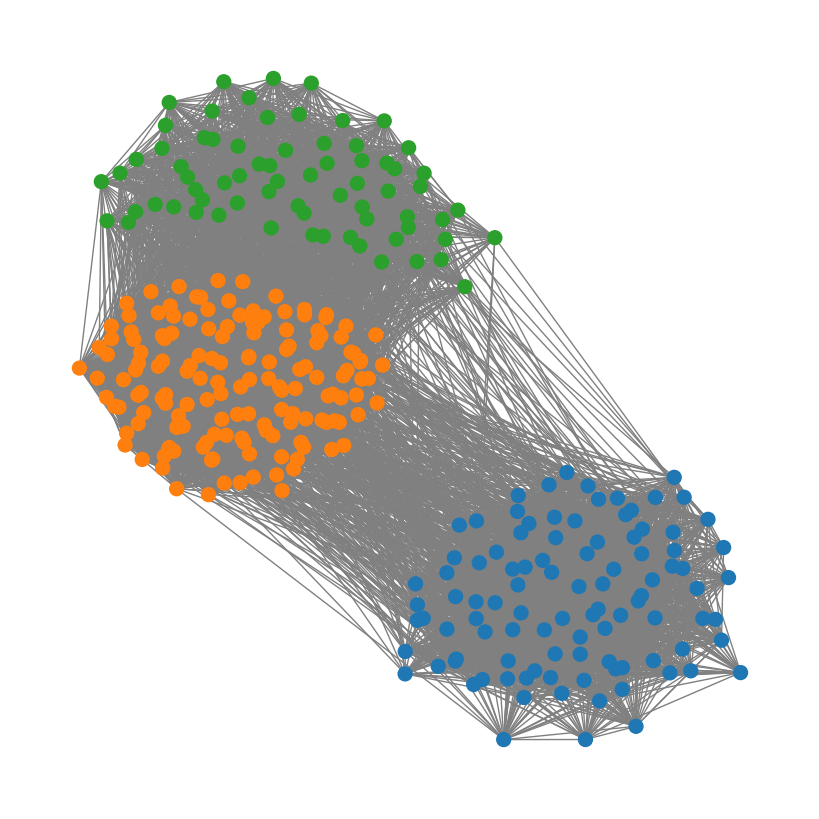

In [95]:
n_classes = [100, 150, 70]

probs = np.array([
    [0.4, 0.03, 0.01],
    [0.03, 0.5, 0.1],
    [0.01, 0.1, 0.4]
])

G = generate_sbm(n_classes, probs)

plot_sbm(G, n_classes)


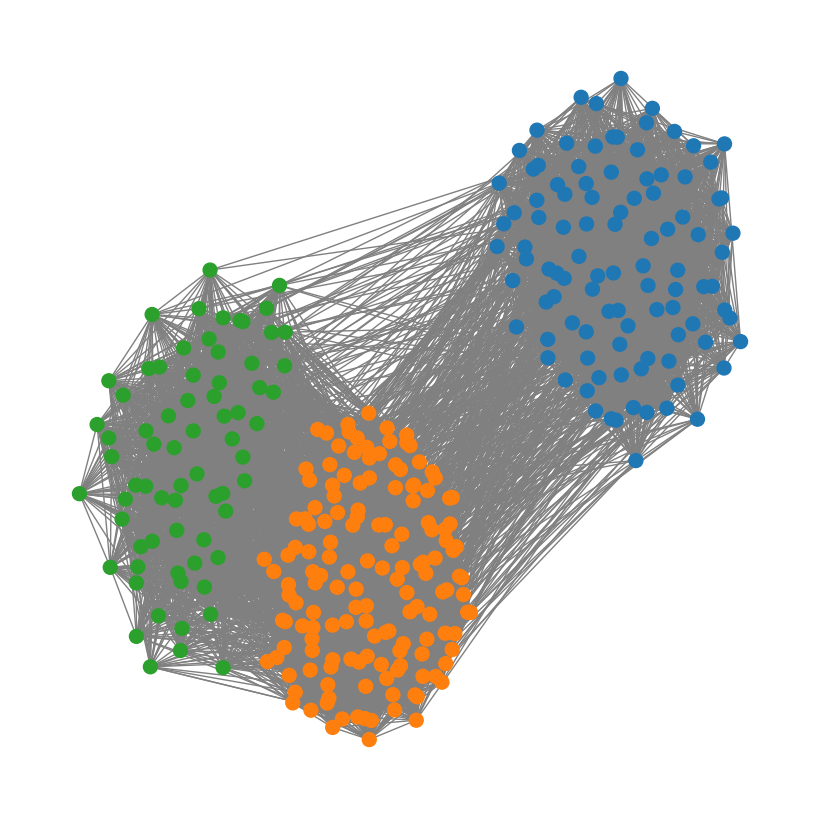

In [96]:
sbm = MySbmFromScratch()

sbm.generate_graph(n_classes = n_classes, probs = probs)
sbm.plot_graph()


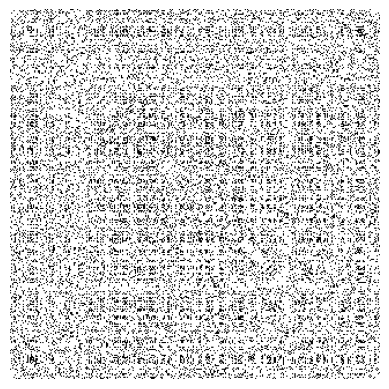

In [27]:
_ = random_permute_adj(sbm.adj) # Plus visuel pour voir si un algo a bien performer
# Ie on voit bien que la avec des indices aléatoires la matrice d'agence ne ressemble a rien..

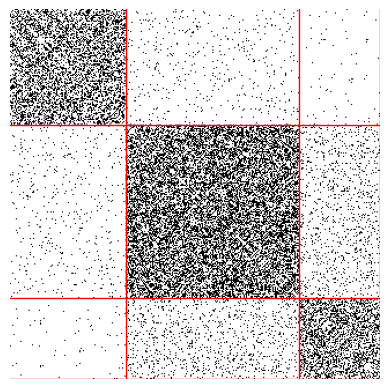

In [28]:
sbm.plot_adj()

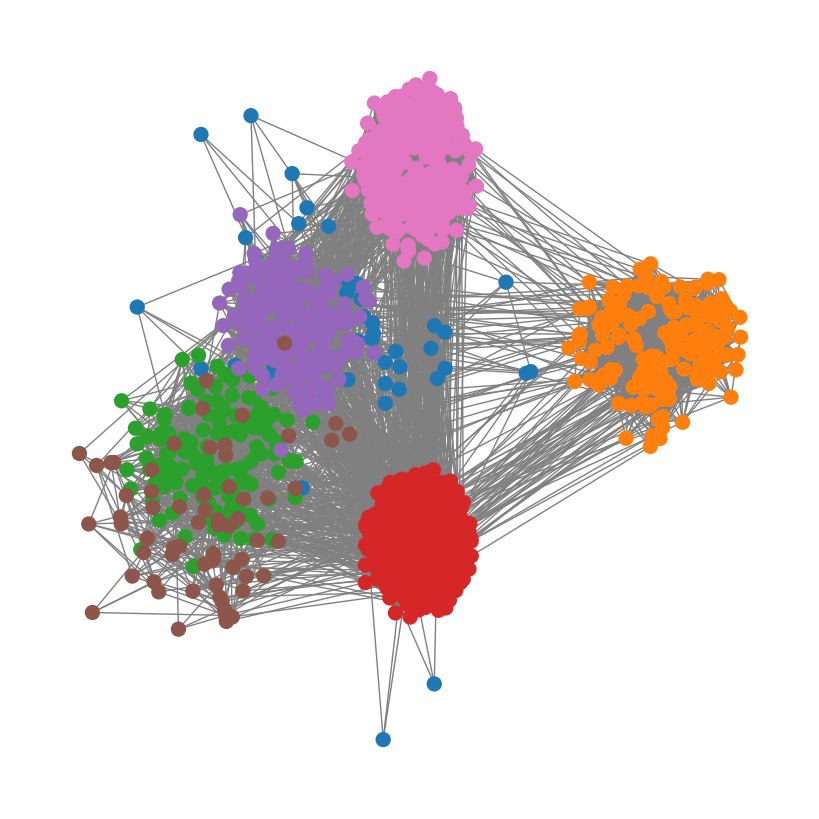

In [64]:
sbm = MySbmFromScratch()

sbm.generate_graph(N = 1500, K=7, _lambda=0.1, multiplier=0.08, alpha=1.5)
sbm.plot_graph()


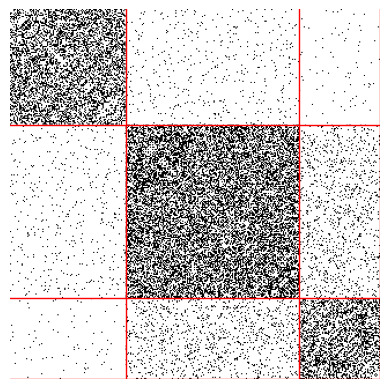

In [147]:
sbm.plot_adj()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


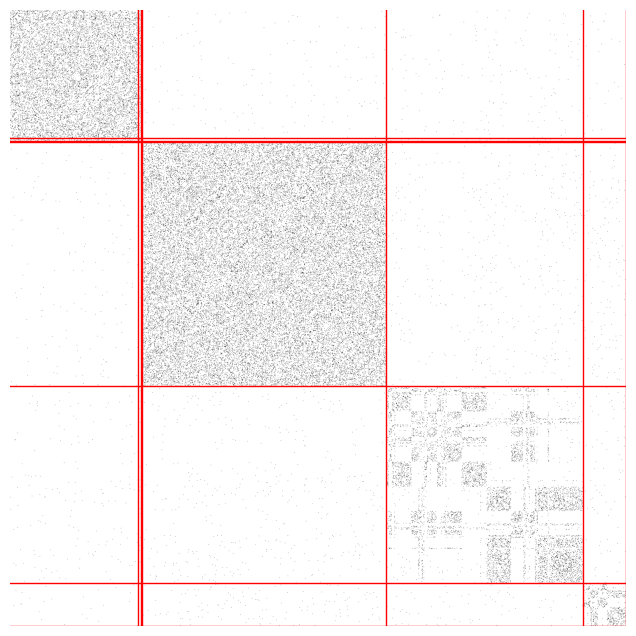

In [ ]:
class MixtureModel():
    def __init__(self, X, n, k, device='cpu'):
        self.device = torch.device(device)
        self.N = n
        self.K = k
        self.logs_like = []
        self.X = torch.tensor(X, dtype=torch.float, device=self.device)
        self.tau = self._init_tau()
    
    def _init_tau(self):
        tau = torch.rand(self.N, self.K, device=self.device)
        tau /= tau.sum(dim=1, keepdim=True)
        return tau

    def _init_tau_sparse(self, sparse=1):

        if sparse > self.K:
            raise ValueError("Pas de valeurs non nulles supérieurs au nombre de classe (baisser sparse).")

        indices = torch.stack([torch.randperm(self.K, device=self.device)[:sparse] for _ in range(self.N)])

        values = torch.rand((self.N, sparse), device=self.device)
        values /= values.sum(dim=1, keepdim=True)

        tau = torch.zeros((self.N, self.K), device=self.device)

        row_indices = torch.arange(self.N, device=self.device).repeat_interleave(sparse)
        col_indices = indices.flatten()
        tau[row_indices, col_indices] = values.flatten()
        
        return tau

    def laplacian_matrix(self):
        adj_matrix = self.X.copy()
        degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
        return degree_matrix - adj_matrix

    def spectral_clustering(self):
        L = self.laplacian_matrix()
        k = self.K
        eigvals, eigvecs = np.linalg.eigh(L)
    
        eigvecs_k = eigvecs[:, :k]
    
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(eigvecs_k)
        
        return kmeans.labels_

    def _init_spectral(self):
        tau = torch.zeroes(self.N, self.K, device=self.device)
        labels = self.spectral_clustering()
        for i in range(self.N):
            tau[i,labels[i]] = 1
        return tau

    def _init_K_means(self, max_iter=5):
        adj_matrix = self.X.cpu().numpy().copy()
        centroids = []
        first_centroid = random.randint(0, self.N - 1)
        centroids.append(first_centroid)
        k = self.K

        #We choose one after another the other centroids by choosing the node thax maximize the minimum distance between the already chosen centroids
        for _ in range(1, k):
            distances_to_centroids = np.min(euclidian_distances(adj_matrix)[:, centroids], axis=1)
            farthest_node = np.argmax(distances_to_centroids)
            centroids.append(farthest_node)
            
        labels = np.zeros(self.N)
        
        for _ in range(max_iter):

            distances = euclidian_distances(adj_matrix)
            for i in range(self.N):
                min_dist = float('inf')
                closest_centroid = -1
                for c in centroids:
                    dist = distances[i, c]
                    if dist < min_dist:
                        min_dist = dist
                        closest_centroid = c
                labels[i] = closest_centroid

            new_centroids = []
            for c in range(k):
                cluster_nodes = [i for i in range(self.N) if labels[i] == c]
                if cluster_nodes:
                    new_centroid = np.mean(adj_matrix[cluster_nodes], axis=0)
                    closest_node = np.argmin(np.sum((adj_matrix - new_centroid) ** 2, axis=1))
                    new_centroids.append(closest_node)
                else:

                    new_centroids.append(random.randint(0, self.N - 1))
            
            if np.array_equal(centroids, new_centroids):
                break
            centroids = new_centroids
        tau = torch.zeros(self.N, k)

        labels = convert_to_ranks(labels)
        for i in range(self.N):
            tau[i] = torch.zeros(k, dtype=torch.float)
            tau[i][int(labels[i])] = 1
        return torch.tensor(tau, dtype=torch.float).to(self.device)
        
    def comp_alpha_pi(self, tau):

        mask = 1 - torch.eye(self.N, device=self.device)  # Diagonal mask to exclude self-loops

        numerator = torch.einsum('iq,jl,ij->lq', tau, tau, self.X * mask)
        denominator = torch.einsum('iq,jl,ij->lq', tau, tau, mask.float())
        

        pi = numerator / denominator
        alpha = tau.mean(dim=0)   

        return alpha, pi  # (K), (KxK)

    def compute_tau(self, alpha, pi, tau, epsilon=1e-10):
        N, K = tau.size()


        pi = torch.clamp(pi, min=epsilon, max=1 - epsilon)
        
        X_expanded = self.X.unsqueeze(-1).unsqueeze(-1)  # (N, N, 1, 1)
        pi_expanded = pi.unsqueeze(0).unsqueeze(0)  # (1, 1, K, K)

        log_b = X_expanded * torch.log(pi_expanded) + (1 - X_expanded) * torch.log(1 - pi_expanded)

        tau_expanded = tau.unsqueeze(0).unsqueeze(-1)  # (1, N, K, 1)
        log_b_tau = log_b * tau_expanded  # (N, N, K, K)

        mask = 1 - torch.eye(N, device=self.device).unsqueeze(-1).unsqueeze(-1)  # (N, N, 1, 1)
        masked_log_b_tau = log_b_tau * mask

        sum_jl = torch.einsum('ijnq->iq', masked_log_b_tau)  # (N, K)

        log_alpha = torch.log(alpha + epsilon).unsqueeze(0)  # (1, K)

        log_tau = log_alpha + sum_jl
        log_tau = log_tau - log_tau.logsumexp(dim=1, keepdim=True)  # Normalization in log-space

        tau_new = torch.exp(log_tau)  # Back to probability space
        
        return tau_new

    def _Q(self, alpha, pi, tau):

        term1 = torch.einsum('iq,q->', tau, alpha)

        theta = torch.einsum('iq,jl->ijql', tau, tau)

        log_b = self.X.unsqueeze(-1).unsqueeze(-1) * torch.log(pi) + (1 - self.X.unsqueeze(-1).unsqueeze(-1)) * torch.log(1 - pi)

        mask = torch.triu(torch.ones(self.N, self.N), diagonal=1).to(self.device)
        masked_theta = theta * mask.unsqueeze(-1).unsqueeze(-1)

        term2 = torch.einsum('ijql,ijql->', masked_theta, log_b)

        return term1 + term2


    def _likelihood(self, alpha, pi, tau):
        term1 = torch.einsum('iq,q->', tau, torch.log(alpha))

        X_unsqueezed = self.X.unsqueeze(-1).unsqueeze(-1)  # (N, N, 1, 1)
        log_b = (
            X_unsqueezed * torch.log(pi) + (1 - X_unsqueezed) * torch.log(1 - pi)
        )
        term2 = 0.5 * torch.einsum('iq,jl,ijql->', tau, tau, log_b)

        epsilon = 1e-10
        term3 = -torch.einsum('iq,iq->', tau, torch.log(tau + epsilon))

        result = term1 + term2 + term3
        return result

    def _fixed_point_algorithm(self, alpha, pi, tau_initial, tol=1e-6, max_iter=100):
        tau = tau_initial.clone()
        for i in range(max_iter):
            tau_new = self.compute_tau(alpha, pi, tau)
            diff = torch.norm(tau_new - tau, p='fro')
            if diff < tol:
                break
            tau = tau_new

        return tau

    def em(self, max_it=50, tolerance=1e-10, upd_params=True, verbose=True,
           tau=None, log_path=False):
        if tau==None:
            tau = self.tau
        logs_like = []
        prev_value = -float('inf')
        for _ in trange(max_it) if verbose else range(max_it):
            alpha, pi = self.comp_alpha_pi(tau)  # M step

            tau = self._fixed_point_algorithm(alpha, pi, tau)  # E step

            likeli = self._likelihood(alpha, pi, tau)  # Compute likelihood
            logs_like.append(likeli.item())
            if abs(likeli - prev_value) < tolerance:
                break
            prev_value = likeli

        if upd_params:
            self.alpha, self.pi, self.tau = alpha.cpu().numpy(), pi.cpu().numpy(), tau
        
        if log_path:
            return (alpha.cpu().numpy(), pi.cpu().numpy(), tau, logs_like)

        return alpha.cpu().numpy(), pi.cpu().numpy(), tau

    def _ICL(self, tau, Q, init=False):
        if init:
            self.__init__(self.X.cpu().numpy(), self.N, Q, device=self.device)
            self.em()
        tau = tau.to(self.device)
        alpha, pi = self.comp_alpha_pi(tau)
        n = self.N
        term = (1 / 4) * Q * (Q + 1) * np.log((n * (n - 1)) / 2) + ((Q - 1) / 2) * np.log(n)
        return self._likelihood(alpha, pi, tau).item() - term
    
    def _BIC(self, tau, Q):
        alpha, pi = self.comp_alpha_pi(tau)
        return -2*self.likelihood(alpha, pi, tau) + Q * np.log(self.N)

    def _AIC(self, tau, Q):
        alpha, pi = self.comp_alpha_pi(tau)
        return -2*self.likelihood(alpha, pi, tau) + 2 * Q        

    def discrete_distribution(self, x):
        cum_dist = torch.tensor(x.cumsum(0), dtype=torch.float)
        rand_val = np.random.rand()
        return torch.searchsorted(cum_dist, rand_val).item()

    def plot_from_tau(self, determinist=True):
        G = nx.from_numpy_array(self.X.cpu().numpy().astype(int))
        tau = self.tau.cpu().numpy()
        classes = [i for i in range(self.K)]
        for i, x in enumerate(tau):
            G.nodes[i]['cluster'] = np.argmax(x) if determinist else self.discrete_distribution(x)
        colors = {classe: plt.cm.tab10(i) for i, classe in enumerate(classes)}
        node_colors = [colors[G.nodes[i]['cluster']] for i in range(len(tau))]
        pos = nx.spring_layout(G)  
        plt.figure(figsize=(8, 6))        
        nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors, font_size=15, font_weight='bold', edge_color='gray')
        plt.show()

    def loss(self, G, determinist = True):
        #if determinist : return the number of mismatch
        #else : return the sum of 1 - the probability of correct match 
        perm = list(permutations([i for i in range(self.K)]))
        minS = self.N
        minp = perm[0]
        
        for p in list(perm): 
            S = 0
            if determinist:
                for i, x in enumerate(self.tau):
                    if np.argmax(x.cpu()) != p[G.nodes[i]['block']]:
                        S += 1
            else:
                for i, x in enumerate(self.tau):
                    S += (1-x[p[G.nodes[i]['block']]])
            minS = min(S,minS)
            minp = p
            
        return minS


    def plot_preds_adjancy(self, tau):
        """
        Visualise une matrice d'adjacence regroupée selon les classes des prédites.

        adj (np.ndarray) : La matrice d'agency carrée (N x N).

        """

        classes = np.array(tau.argmax(dim=1).cpu())

        sorted_indices = np.argsort(classes)

        adj_sorted = self.X[np.ix_(sorted_indices, sorted_indices)].cpu().numpy()

        unique_classes, counts = np.unique(classes, return_counts=True)
        cumulative_indices = np.cumsum(counts)

        plt.figure(figsize=(8, 8))
        plt.imshow(-adj_sorted, cmap="gray", extent=(0, adj_sorted.shape[1],
                   adj_sorted.shape[0], 0))
        plt.axis("off")

        for index in cumulative_indices:
            plt.axhline(y=index, color='red', linestyle='-', linewidth=1)
            plt.axvline(x=index, color='red', linestyle='-', linewidth=1)

        plt.show()

    def em_parallelised(self, num_inits=5, max_it=50, tolerance=1e-10,
                        upd_params=True, return_params=False, init=""):

        results = []
        seeds = range(num_inits)
        m_it = [max_it] * num_inits
        tols = [tolerance] * num_inits
        inits = [init] * num_inits
        with ThreadPoolExecutor(max_workers=num_inits) as executor:
            results = list(executor.map(self.single_em_run, seeds, m_it, tols, inits))

        best_res = max(results, key=lambda x: x['likelihood'])
        if upd_params:
            self.alpha = best_res["alpha"]
            self.pi = best_res["pi"]
            self.tau = best_res["tau"]
            self.logs_like = best_res["logs_like"]
        
        if return_params:
            return best_res

        return best_res["tau"]

    def single_em_run(self, seed, max_it=50, tolerance=1e-10, init=""):
        torch.manual_seed(seed)

        if init == "Kmeans" or "K-means":
            tau_init = self._init_K_means()
        
        elif init == "Spectral":
            tau_init = self._init_spectral()

        tau_init = self._init_tau_sparse()
        alpha, pi, tau, logs_like = self.em(tau= tau_init, max_it=max_it, tolerance=tolerance, verbose=False,
                                           log_path=True)
        likelihood = self._likelihood(torch.tensor(alpha, device=self.device), 
                                        torch.tensor(pi, device=self.device), 
                                        tau.to(self.device))
        return {
            'alpha': alpha,
            'pi': pi,
            'tau': tau,
            'likelihood': likelihood.item(),
            'logs_like': logs_like
        }
    
    def full_proc(self, max_q=8, n_parralels=20, max_it=30, criterion="ICL", init=""):
        all_results = {}
        for Q in trange(2, max_q+1):
            self.K = Q
            all_results[Q] = self.em_parallelised(num_inits=n_parralels, max_it=max_it, 
                                                  upd_params=False, return_params=True, init=init)
            all_results[Q]["criterion"] = self._ICL(all_results[Q]["tau"], Q)
        return all_results


test = MixtureModel(sbm.adj, sbm.adj.shape[0], 7, device='cuda')
_, __, tau = test.em()
test.plot_preds_adjancy(sbm.adj)


In [69]:
res = test.full_proc(max_q= 9, n_parralels=1)

  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_3525/667484074.py:318: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(tau, device=self.device))
  8%|▊         | 4/50 [00:00<00:05,  8.51it/s]
/tmp/ipykernel_3525/667484074.py:216: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(tau, dtype=torch.float).to(self.device)
100%|██████████| 8/8 [11:08<00:00, 83.54s/it] 


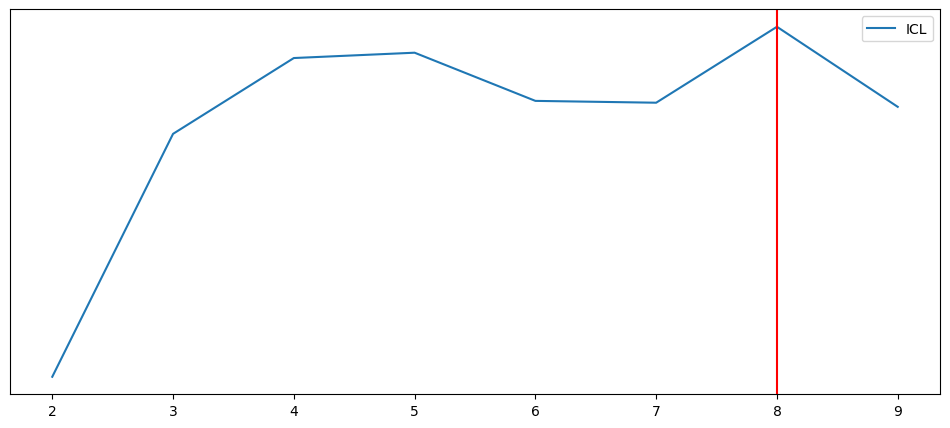

In [83]:
list_vals = []
for key in res.keys():
    list_vals.append(res[key]["criterion"])
plt.figure(figsize=(12,5))
plt.plot([i for i in range(2, 10)], list_vals, label="ICL")
plt.axvline(list_vals.index(max(list_vals))+2, c="r")
plt.yticks([])
plt.legend()
plt.show()

In [84]:
test._Q(torch.tensor(_).to("cuda"), torch.tensor(__).to("cuda"), tau)

tensor(-101231.9844, device='cuda:0')

In [85]:
test._likelihood(torch.tensor(_).to("cuda"), torch.tensor(__).to("cuda"), tau)

tensor(-103652.1016, device='cuda:0')

In [90]:
test.tau = res[8]["tau"].cpu()

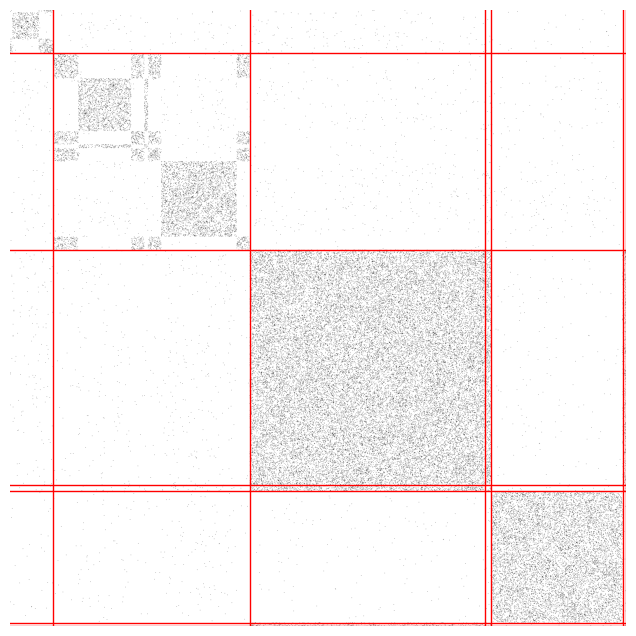

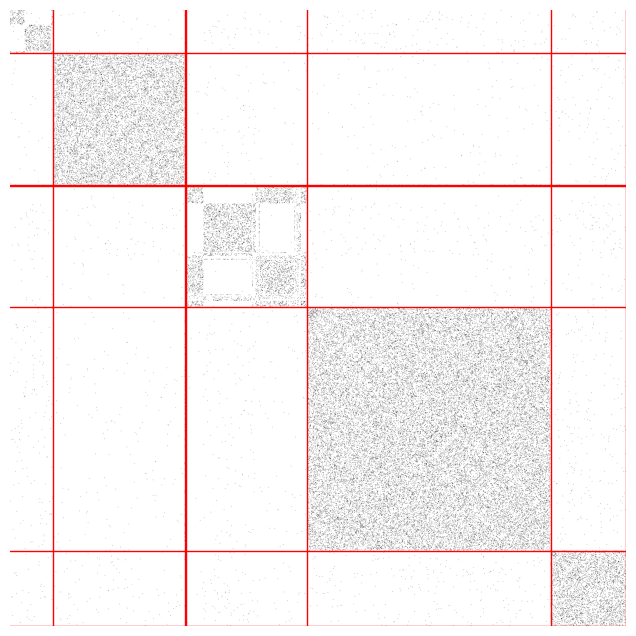

In [93]:
test.tau = res[7]["tau"].cpu()
test.plot_preds_adjancy(sbm.adj)

test.tau = res[8]["tau"].cpu()
test.plot_preds_adjancy(sbm.adj)

In [154]:
test = MixtureModel(sbm.adj, sbm.adj.shape[0], 3, device='cuda')
res = test.full_proc(max_q= 7, n_parralels=1, init="Spectral")


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_3525/3440703006.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tau, dtype=torch.float).to(self.device)
 17%|█▋        | 1/6 [00:00<00:01,  4.57it/s]/tmp/ipykernel_3525/3440703006.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tau, dtype=torch.float).to(self.device)
 33%|███▎      | 2/6 [00:00<00:01,  3.42it/s]/tmp/ipykernel_3525/3440703006.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tau, dtype=torch.float

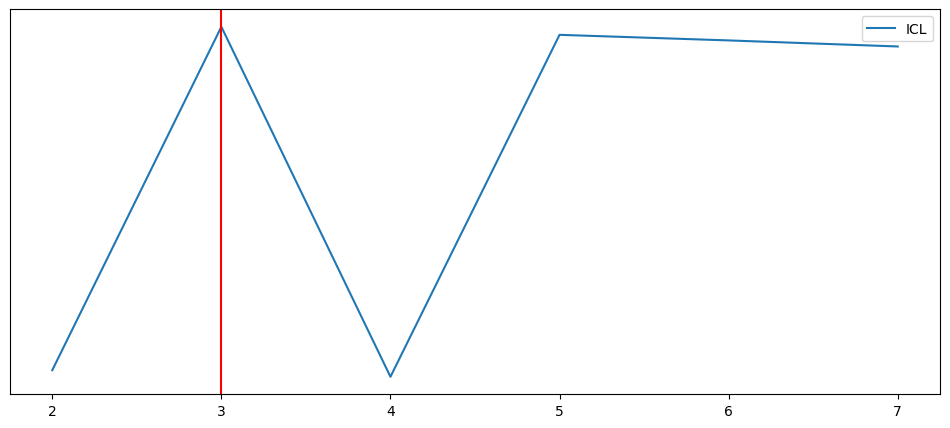

In [159]:
list_vals = []
for key in res.keys():
    list_vals.append(res[key]["criterion"])
plt.figure(figsize=(12,5))
plt.plot([i for i in range(2, 8)], list_vals, label="ICL")
plt.axvline(list_vals.index(max(list_vals))+2, c="r")
plt.yticks([])
plt.legend()
plt.show()

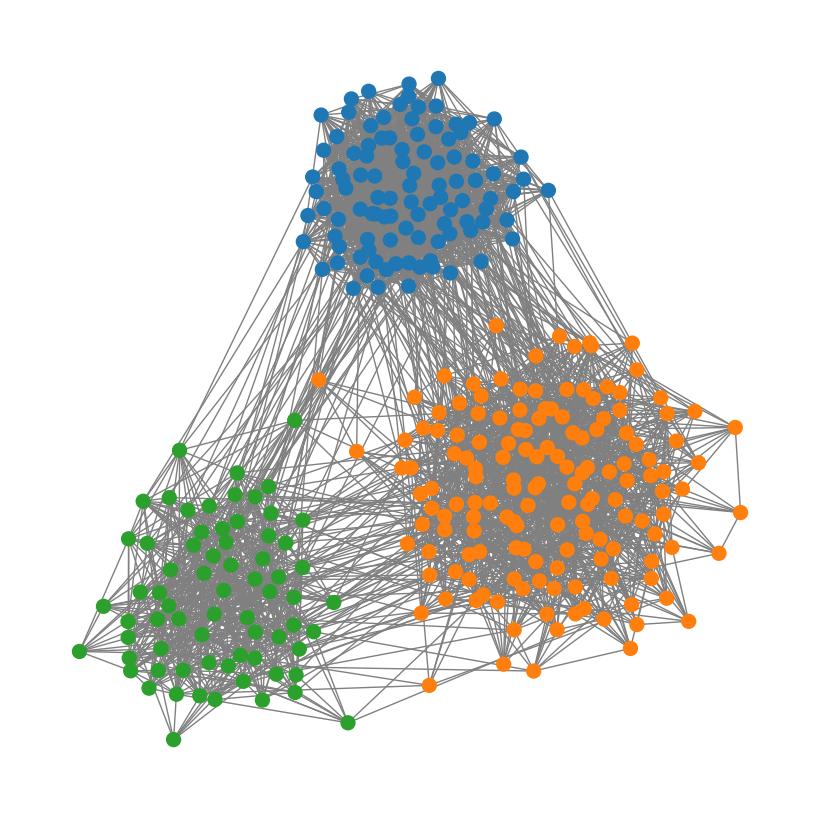

In [94]:
n_classes = [100, 150, 70]

probs = np.array([
    [0.25, 0.01, 0.005],
    [0.01, 0.10, 0.009],
    [0.005, 0.009, 0.2]
])

G3 = generate_sbm(n_classes, probs)

M_3 = get_adjancy(G3.edges, len(G3.nodes))

plot_sbm(G3, n_classes)

100%|██████████| 50/50 [00:03<00:00, 14.77it/s]


36


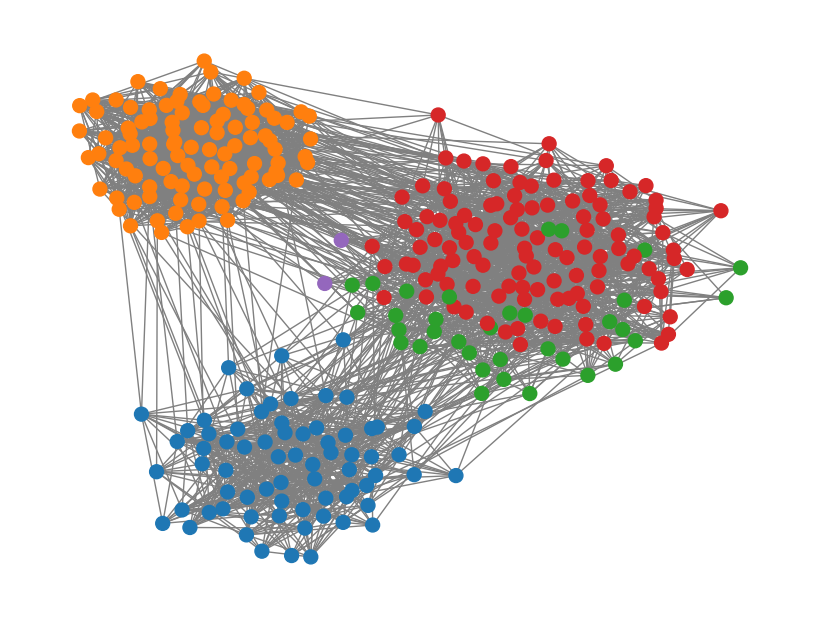

In [ ]:
model3 = MixtureModel(M_3, 320, 5, device="cuda")
model3.em(max_iter)
print(model3.loss(G3, determinist = True))
model3.plot_from_tau()

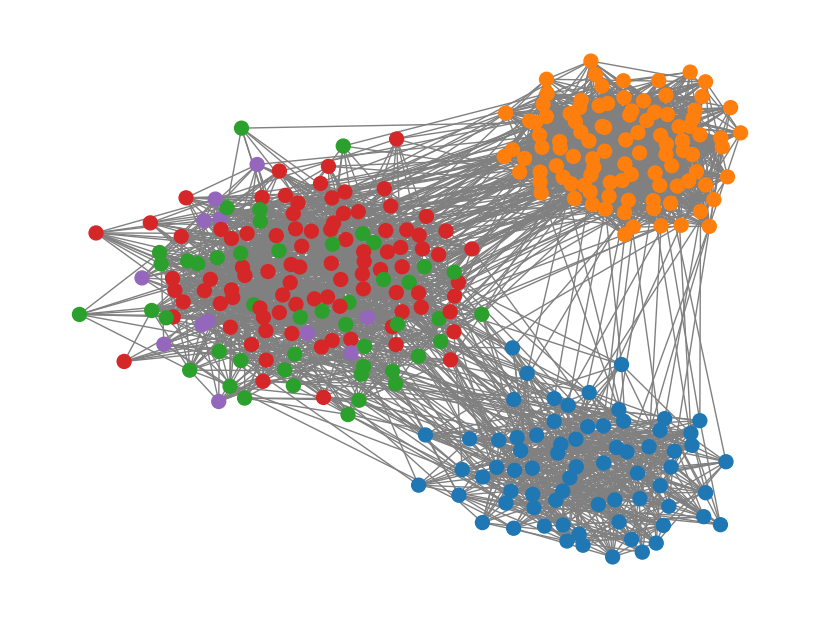

In [ ]:
model3.plot_from_tau(determinist=False)

/tmp/ipykernel_4930/1199093152.py:154: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  classes = np.array(self.tau.argmax(dim=1).cpu())


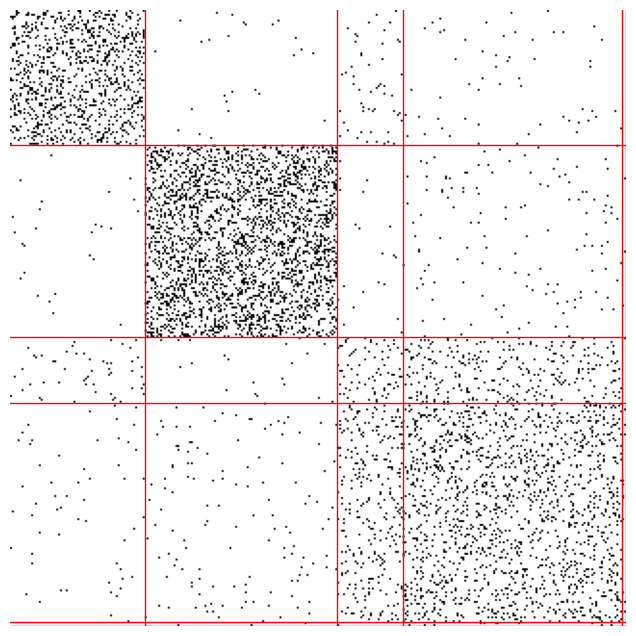

In [ ]:
model3.plot_preds_adjancy(M_3)